In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import floor
from keras import models
from keras import layers
from keras import optimizers
from scipy.integrate import odeint
import scipy

# Descenso del gradiente

In [11]:
#derivada parcial de una función:
#g=función
#k es la variable respecto a la que se deriva X=(x1, x2,..., xk,..)
#X es el punto en el que se evalua la derivada
def partial(g, k, X):
    h = 1e-10
    Y = np.copy(X)
    X[k - 1] = X[k - 1] + h
    dp = (g(X) - g(Y)) / h
    return dp

#Regresa el vector gradiente de una función f evaluando en X, tiene una cota para evitar que explote el valor del gradiente
#pero manteniendo la dirección del mismo
def gradcot(f, X, cota):
    grd = []
    for i in np.arange(0, len(X)):
        #aquí definiremos la cota para el gradiente 
        ai = partial(f, i + 1, X)
        ai=float(ai)
        if ai<0:
            ai = max(ai, -1*cota)
        else:
            ai = min(ai, cota)
        grd.append(ai)
    return grd

#esta función aplica el descenso del gradiente a una función f, comenzando en un punto X0
#eta=learning rate
#steps=número máximo de iteraciones a realizar
#tolerance=norma del vector gradiente en la que ya es buena idea terminar las iteraciones
def desgrad(f,X0,eta, steps, cota, tolerance):
    i=0
    while True:
        i=i+1
        X0=X0-eta*np.array(gradcot(f,X0, cota))

        if np.linalg.norm(gradcot(f,X0, cota))<tolerance or i>steps: break
        
        
    return X0

#nos arroja X0 donde la función debe tener un mínimo

# Descenso del gradiente aplicado a una regresión lineal
El archivo hubble_low_z.txt Contiene 18 supernovas cercanas (solo hasta el corrimiento al rojo $z \sim 1$ donde se encuentra que la relación de Hubble funciona bien. Aunque la ley de Hubble debería tener una ordenanda al origen de 0, ajustaremos una recta con ayuda del perceptrón.

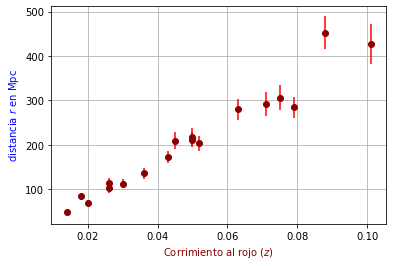

In [12]:
hubble=np.loadtxt('hubble_low_z.txt')
z,r,error=np.split(hubble,3, axis=1)

#graficamos
error=np.reshape(error.T,18)
plt.errorbar(z,r,fmt='o',yerr=error, ecolor='red',color='darkred')
#plt.plot(z,r,'o',color='darkred')
plt.xlabel('Corrimiento al rojo $(z)$',color='darkred')
plt.ylabel('distancia $r$ en Mpc',color='b')
plt.grid()

In [13]:
perceptron =lambda X,W: np.dot(X,W)

In [13]:
x=z
y1=r
x1=[]
for i in x:
    i=np.append(i,1.0)
    x1.append(i)
    
x1=np.array(x1)

In [14]:
def error(W,x=x1,y=r):
    s=0
    for i in range(0,len(y)):
        l=0.5*(np.dot(x1[i],W)-y[i])**2
        s=s+l
    return s


In [16]:
scipy.optimize.minimize(error, [1,1])

      fun: 5227.641727121165
 hess_inv: array([[ 0.77751465, -0.07124084],
       [-0.07124084,  0.04530579]])
      jac: array([-6.10351562e-05,  6.10351562e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 164
      nit: 17
     njev: 51
   status: 2
  success: False
        x: array([4448.86206485,  -12.43375591])

In [17]:
m,b=desgrad(error,[10,1],eta=0.1,steps=10000,tolerance=1e-8,cota=100.0)
print('La pendiente es',m,'y la ordenada es',b)

La pendiente es 4445.31428508585 y la ordenada es -12.258316395122959


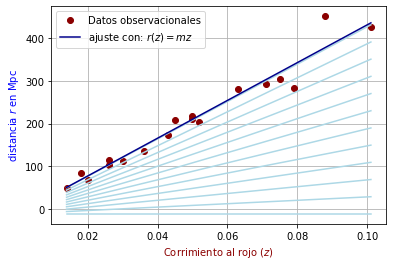

In [18]:
plt.plot(z,r,'o',label='Datos observacionales',color='darkred')
plt.xlabel('Corrimiento al rojo $(z)$',color='darkred')
plt.ylabel('distancia $r$ en Mpc',color='b')
for i in range(0,4445,400):
    plt.plot(z,i*z+b,color='lightblue')
plt.plot(z,m*z+b,label='ajuste con: $r(z)=mz$',color='darkblue')
plt.legend()
plt.grid()

In [15]:
index=np.append(np.arange(1,30,1), np.arange(40,10000,70))
def desgrad1(f,X0,eta, steps, cota, tolerance):
    i=0
    pendientes=[]
    while True:
        i=i+1
        X0=X0-eta*np.array(gradcot(f,X0, cota))

        if np.linalg.norm(gradcot(f,X0, cota))<tolerance or i>steps: break
        
        if i in index:
            pendientes.append(X0)
            
    return pendientes

In [24]:
A=desgrad1(error,[5000,30],eta=0.1,steps=10000,tolerance=1e-8,cota=100.0)

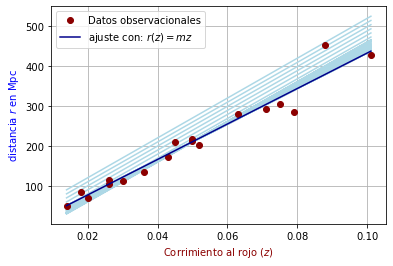

In [25]:
for a in A:
    m,b=a
    plt.plot(z,m*z+b,color='lightblue')
plt.plot(z,r,'o',label='Datos observacionales',color='darkred')
plt.plot(z,4445.53*z-12,label='ajuste con: $r(z)=mz$',color='darkblue')
plt.xlabel('Corrimiento al rojo $(z)$',color='darkred')
plt.ylabel('distancia $r$ en Mpc',color='b')
plt.grid()
plt.legend()

# Definición de las funciones de activación a utilizar


In [19]:
# RELU
def relu(x):
    return x * (x > 0)

def drelu(x):
    return 1. * (x > 0)

#IDENTIDAD
def iden(X):
    return X
def diden(X):
    return 1

#SIGMOIDE
def sigmoid(X):
    return 1/(1+np.exp(-X))
def dsigmoid(X):
    return sigmoid(X)*(1-sigmoid(X))

#TANGENTE HIPORBÓLICA
def tanh(X):
    return np.tanh(X)
def dtanh(X):
    return 1-tanh(X)**2


# Función split para separa un conjunto de datos X,Y
separa un conjunto X,Y en dos pares: $X_{train}$,$Y_{train}$

$X_{val}$,$Y_{val}$

In [2]:
def split(X,Y,porcent): #El porcentaje debe estar dado entre 0 y 1, será el porcentaje que mandará a entrenamiento
    n=floor(porcent*len(X))
    index=random.sample(range(len(X)),n)
    X_learn=[]
    Y_learn=[]
    for i in index:
        X_learn.append(X[i])
        Y_learn.append(Y[i])
    X_val=np.delete(X,index, axis=0)
    Y_val=np.delete(Y,index, axis=0)
    
    X_learn=np.array(X_learn)
    Y_learn=np.array(Y_learn)
    
    return X_learn,Y_learn,X_val,Y_val


# Definición del forward propagation
Este forward es para una red de una sola capa oculta 

In [21]:
#Definimos el forward propagation por si se quiere evaluar un determiado valor después de haber entrenado la red
def forward(X,W1,b1,W2,b2,activation):
    z1=np.dot(X,W1)+b1
    a1=activation(z1)
    z2=np.dot(a1,W2)+b2
    a2=z2
    return a2

# Función de coste

In [22]:
#función de coste:
def error(C):
    m=len(C)
    e=(1/(2*m))*np.linalg.norm(C)**2
    return e

# Red neuronal de una sola capa
X,Y= conjunto de datos
nodos=número de nodos que llevará la capa oculta
batch_size (Este debería decir split_size, pero no lo cambio para evitar errores)
activation=le decimos cuál de las funciones que definimos arriba queremos usar
así como su derivada correspondiente

#### Además de graficarnos el error, nos regresa los parámetros de la red W, b para su uso posterior

In [23]:
def neuralnet(X,Y,nodos,batch_size,learning_rate,epocas,activation,dactivation):
    #Definimos la estructura de la red
    n_entradas=len(X[0])
    n_salidas=len(Y[0])
    
    #definimos los conjuntos de aprendizaje y validación 
    X_learn,Y_learn,X_val,Y_val = split(X,Y,batch_size)
    
    #forward
    W1=np.random.randn(n_entradas,nodos)
    W2=np.random.randn(nodos,n_salidas)
    b1=np.random.randn(nodos)
    b2=np.random.randn(n_salidas)
    
    #z1=np.dot(X_learn,W1)+b1
    #a1=activation(z1)
    #z2=np.dot(a1,W2)+b2
    #a2=z2
    
    #épocas
    errores=[]
    validacion=[]
    for i in range(epocas+1):
        #Forward
        z1=np.dot(X_learn,W1)+b1
        a1=activation(z1)
        z2=np.dot(a1,W2)+b2
        a2=z2
        
        #backpropagation
        delta2 = a2-Y_learn
        delta1 = (delta2).dot(W2.T)*dactivation(z1)
        
        errores.append(error(delta2)) #guardamos el error de cada época

        W2 -= learning_rate * a1.T.dot(delta2)
        b2 -= learning_rate * (delta2).sum(axis=0)

        W1 -= learning_rate * X_learn.T.dot(delta1)
        b1 -= learning_rate * (delta1).sum(axis=0)
        print("Época %d, coste %f" %(int(i),error(delta2)))
        
        #Ahora validamos el modelo
        z1=np.dot(X_val,W1)+b1
        a1=activation(z1)
        z2=np.dot(a1,W2)+b2
        a2=z2
        delta = a2-Y_val
        validacion.append(error(delta))
        
    plt.plot(range(i+1),errores,color='darkcyan',label='Aprendizaje')
    plt.plot(range(i+1),validacion,color='darkred',label='Validación')
    plt.grid()
    plt.legend()
    return W1,b1,W2,b2

# Una red parecida, pero con Keras

In [5]:
nodos=10
split_size=0.8
learning_rate=0.1
epocas=100

#Separamos los datos en validación y entrenamiento
X_learn,Y_learn,X_val,Y_val=split(X,Y,split_size)

#Armamos el modelo con estructura 'Sequential'
model=models.Sequential()

#la primer capa recibe un numero solamente, usaremos sigmoide como función de activación para la capa oculta
capa1=layers.Dense(nodos, input_shape=(len(X[0]),),use_bias=1,activation='sigmoid')
#para la capa de salida usamos Id como activación
salida=layers.Dense(len(Y[0]),use_bias=1)

#armamos el modelo
model.add(capa1)
model.add(salida)
#Ahora definimos el paso de compilación, con learning rate=0.001
#Función de error cuadrático medio


model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse')

#por último traemos los datos de entrenamiento y los procesamos con 'fit()'
history=model.fit(X_learn,Y_learn,validation_data=(X_val, Y_val),batch_size=4,epochs=epocas,shuffle=True)

error=history.history['loss']
exac=history.history['val_loss']
epochs=np.arange(0,len(error))
plt.plot(epochs,error,label='Error entrenamiento',color='darkblue')
plt.plot(epochs,exac,label='Error Validación',color='r')
plt.legend()
plt.grid()
plt.title('Error durante el entrenamiento',color='red')

NameError: name 'X' is not defined

# Ajuste a la ecuación de Friedmann con ambas redes

###### Importamos los datos para esta sección


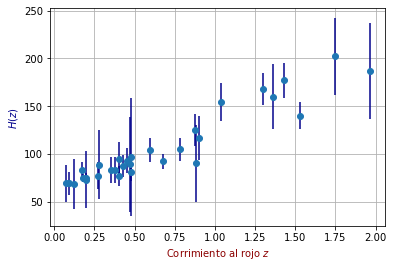

In [2]:
datosH=low_z=np.loadtxt('datosH.txt')

zH0,H,errorH0=np.split(datosH,3,axis=1)
errorH0=np.reshape(errorH0.T,31)
plt.errorbar(zH0,H,fmt='o',yerr=errorH0, ecolor='darkblue')
plt.xlabel('Corrimiento al rojo $z$', color='darkred')
plt.ylabel('$H(z)$', color='darkblue')
plt.grid()

In [7]:
#Función a emular
def Hlcdm(z, Om=0.27, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)


X=2.3*np.random.rand(1000,1)
Y=Hlcdm(X, Om=0.27, H0=73.24)

# Con la red trucha

Época 0, coste 10731.761707
Época 1, coste 9629.361078
Época 2, coste 8188.201665
Época 3, coste 6562.558492
Época 4, coste 5066.439824
Época 5, coste 3896.830244
Época 6, coste 3051.894103
Época 7, coste 2427.891846
Época 8, coste 1954.787354
Época 9, coste 1621.853073
Época 10, coste 1400.135207
Época 11, coste 1251.831048
Época 12, coste 1148.110403
Época 13, coste 1069.443115
Época 14, coste 1001.537832
Época 15, coste 933.289518
Época 16, coste 857.367204
Época 17, coste 774.681121
Época 18, coste 695.408125
Época 19, coste 624.416063
Época 20, coste 561.048381
Época 21, coste 505.426884
Época 22, coste 456.901732
Época 23, coste 414.648956
Época 24, coste 377.791643
Época 25, coste 345.510686
Época 26, coste 317.102676
Época 27, coste 291.982016
Época 28, coste 269.663637
Época 29, coste 249.745364
Época 30, coste 231.892894
Época 31, coste 215.827431
Época 32, coste 201.315578
Época 33, coste 188.161116
Época 34, coste 176.198335
Época 35, coste 165.286647
Época 36, coste 155.30

Época 313, coste 6.974210
Época 314, coste 7.633780
Época 315, coste 6.906005
Época 316, coste 7.554104
Época 317, coste 6.838723
Época 318, coste 7.475557
Época 319, coste 6.772348
Época 320, coste 7.398122
Época 321, coste 6.706865
Época 322, coste 7.321779
Época 323, coste 6.642260
Época 324, coste 7.246511
Época 325, coste 6.578517
Época 326, coste 7.172300
Época 327, coste 6.515622
Época 328, coste 7.099128
Época 329, coste 6.453561
Época 330, coste 7.026979
Época 331, coste 6.392319
Época 332, coste 6.955834
Época 333, coste 6.331883
Época 334, coste 6.885677
Época 335, coste 6.272239
Época 336, coste 6.816491
Época 337, coste 6.213374
Época 338, coste 6.748260
Época 339, coste 6.155274
Época 340, coste 6.680968
Época 341, coste 6.097928
Época 342, coste 6.614600
Época 343, coste 6.041322
Época 344, coste 6.549140
Época 345, coste 5.985445
Época 346, coste 6.484573
Época 347, coste 5.930286
Época 348, coste 6.420885
Época 349, coste 5.875831
Época 350, coste 6.358061
Época 351, c

Época 693, coste 1.828077
Época 694, coste 1.877044
Época 695, coste 1.819116
Época 696, coste 1.867615
Época 697, coste 1.810223
Época 698, coste 1.858260
Época 699, coste 1.801397
Época 700, coste 1.848979
Época 701, coste 1.792638
Época 702, coste 1.839770
Época 703, coste 1.783946
Época 704, coste 1.830632
Época 705, coste 1.775319
Época 706, coste 1.821566
Época 707, coste 1.766756
Época 708, coste 1.812570
Época 709, coste 1.758258
Época 710, coste 1.803643
Época 711, coste 1.749822
Época 712, coste 1.794784
Época 713, coste 1.741449
Época 714, coste 1.785993
Época 715, coste 1.733138
Época 716, coste 1.777269
Época 717, coste 1.724888
Época 718, coste 1.768611
Época 719, coste 1.716699
Época 720, coste 1.760018
Época 721, coste 1.708569
Época 722, coste 1.751490
Época 723, coste 1.700499
Época 724, coste 1.743026
Época 725, coste 1.692487
Época 726, coste 1.734625
Época 727, coste 1.684533
Época 728, coste 1.726286
Época 729, coste 1.676636
Época 730, coste 1.718010
Época 731, c

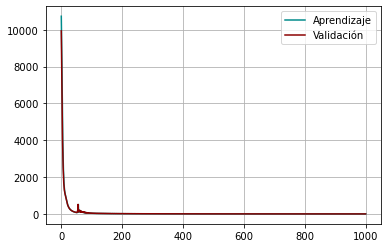

In [28]:
W1,b1,W2,b2=neuralnet(X,Y,10,0.2,0.0001,1000,activation=sigmoid,dactivation=dsigmoid)

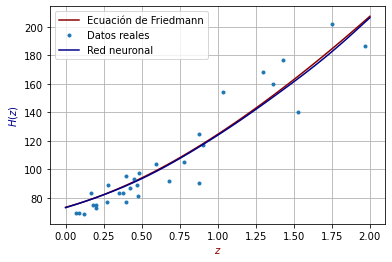

In [36]:
z=np.linspace(0,2,60)
z=z.reshape(60,1)
plt.plot(z,Hlcdm(z, Om=0.27, H0=73.24),color='darkred',label='Ecuación de Friedmann')
plt.plot(zH0,H,'.', label='Datos reales')
plt.plot(z,forward(z,W1,b1,W2,b2,sigmoid),label='Red neuronal',color='darkblue')
plt.xlabel('$z$', color='darkred')
plt.ylabel('$H(z)$', color='darkblue')
plt.legend()
plt.grid()

# Con Keras

Epoch 1/100
200/200 [==============================] - 1s 1ms/step - loss: 9745.7822 - val_loss: 403.9378
Epoch 2/100
200/200 [==============================] - 0s 757us/step - loss: 217.3382 - val_loss: 86.4596
Epoch 3/100
200/200 [==============================] - 0s 685us/step - loss: 17.7193 - val_loss: 24.3736
Epoch 4/100
200/200 [==============================] - 0s 679us/step - loss: 16.6347 - val_loss: 1.1788
Epoch 5/100
200/200 [==============================] - 0s 745us/step - loss: 12.7281 - val_loss: 44.9358
Epoch 6/100
200/200 [==============================] - 0s 730us/step - loss: 11.7260 - val_loss: 0.9289
Epoch 7/100
200/200 [==============================] - 0s 684us/step - loss: 11.6938 - val_loss: 14.9528
Epoch 8/100
200/200 [==============================] - 0s 684us/step - loss: 9.4734 - val_loss: 1.3859
Epoch 9/100
200/200 [==============================] - 0s 764us/step - loss: 10.6216 - val_loss: 16.9244
Epoch 10/100
200/200 [==============================] - 0

Text(0.5, 1.0, 'Error durante el entrenamiento')

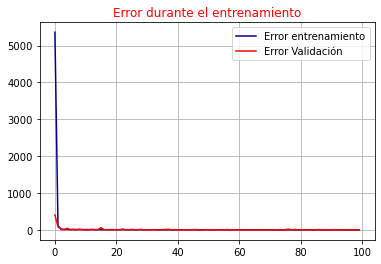

In [17]:
nodos=10
split_size=0.8
learning_rate=0.1
epocas=100

#Separamos los datos en validación y entrenamiento
X_learn,Y_learn,X_val,Y_val=split(X,Y,split_size)

#Armamos el modelo con estructura 'Sequential'
model=models.Sequential()

#la primer capa recibe un numero solamente, usaremos sigmoide como función de activación para la capa oculta
capa1=layers.Dense(nodos, input_shape=(len(X[0]),),use_bias=1,activation='sigmoid')
#para la capa de salida usamos Id como activación
salida=layers.Dense(len(Y[0]),use_bias=1)

#armamos el modelo
model.add(capa1)
model.add(salida)
#Ahora definimos el paso de compilación, con learning rate=0.001
#Función de error cuadrático medio


model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse')

#por último traemos los datos de entrenamiento y los procesamos con 'fit()'
history=model.fit(X_learn,Y_learn,validation_data=(X_val, Y_val),batch_size=4,epochs=epocas,shuffle=True)

error=history.history['loss']
exac=history.history['val_loss']
epochs=np.arange(0,len(error))
plt.plot(epochs,error,label='Error entrenamiento',color='darkblue')
plt.plot(epochs,exac,label='Error Validación',color='r')
plt.legend()
plt.grid()
plt.title('Error durante el entrenamiento',color='red')

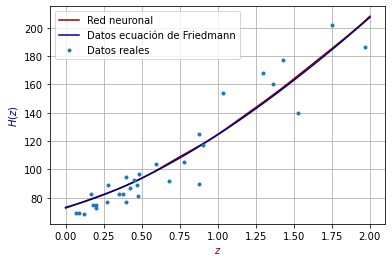

In [19]:
z=np.linspace(0,2,60)
z=z.reshape(60,1)
plt.plot(z,model.predict(z),label='Red neuronal',color='darkred')
plt.plot(z,Hlcdm(z, Om=0.27, H0=73.24),color='darkblue',label='Datos ecuación de Friedmann')
plt.plot(zH0,H,'.', label='Datos reales')
plt.xlabel('$z$', color='darkred')
plt.ylabel('$H(z)$', color='darkblue')
plt.grid()
plt.legend()

# Entrenamiento con ecuaciones diferenciales

#### Sistema de ecuaciones
Resolver:

$\dot \rho_i + 3(1+\gamma)H\rho_i = 0$

$H^2 = \frac{\kappa_0}{3}\sum \rho_i$

Cambiando variables, a:

$\Omega_i = \frac{\kappa_0 }{3H^2} \rho_i$ 

# 1. Transformamos la EDO en una función

In [18]:
def RHS(Omega_i, lna, gamma=0):
    x, y, z, H = Omega_i
    #x, y, z = Omega_i
    pi = 3*x + 4*y
    return [x*(-3 + pi), y*(-4 + pi), z*pi, -0.5*H*pi]
    #return [x*(-3 + pi), y*(-4 + pi), z*pi]

def EDO(t,Om,H0):
    #t,Or,Om,Ol=X
    Or=0.0001
    Ol=1-Or-Om
    #H0 = 70.
    y0 = [Om, Or, Ol, H0]
    result = odeint(RHS, y0, t)
    return result

# 2. Gneramos el conjunto de datos 
Con las suficientes combinaciones de $\Omega _i$ como para que el algrtimo aprenda
Vamos a variar 



$O_m \in [0.1, 0.5]$

$H_0 \in [65, 80]$

$t \in [0,-12]$



In [19]:
#O_m=np.linspace(0.1,0.5,50)
O_m=np.arange(0.1,0.51,0.01)
#O_r=np.linspace(0.0001,0.0010,50)
#O_r=np.arange(0.0001,0.0010,0.0001)
H_0=np.arange(66,81,1)
t=np.linspace(0,-12,50)

##### hacemos la combinatoria de estos conjuntos

In [20]:
Y0=[]
#este ciclo llena la lista fijando un Om y pasando todos los Or
for i in O_m:
    for j in H_0:
        Y0.extend(EDO(t,i,j))
Y0=np.array(Y0)

X0=[]
for Om in O_m:
    for H0 in H_0:
        for T in t:
            X0.append([T,Om,H0])
X0=np.array(X0)

#### Como la cuarta componente de las soluciones toma valores muy grandes, vamos a estandarizar al conjunto Y con una transformación de máximo-mínimo. Luego al evaluarla será necesario aplicar la transformación inversa a la salida de la red

In [21]:
from sklearn import preprocessing


In [22]:
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
Y2 = scaler.fit_transform(Y0)

Se usó la siguiente estructura de red, ya no la corro, pero adjunto el modelo y el error que tuvo durante las épocas
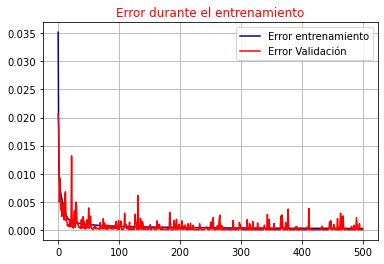

In [ ]:
#Dos paredes ocultas
nodos=150
split_size=0.8
learning_rate=0.001
epocas=500

#Separamos los datos en validación y entrenamiento
X_learn,Y_learn,X_val,Y_val=split(X0,Y2,split_size)

#Armamos el modelo con estructura 'Sequential'
model=models.Sequential()

#la primer capa recibe un numero solamente, usaremos sigmoide como función de activación para la capa oculta
capa1=layers.Dense(nodos, input_shape=(3,),use_bias=1,activation='sigmoid')
capa2=layers.Dense(nodos,use_bias=1,activation='sigmoid')
capa3=layers.Dense(nodos,use_bias=1,activation='sigmoid')
capa4=layers.Dense(nodos,use_bias=1,activation='sigmoid')
#para la capa de salida usamos Id como activación
salida=layers.Dense(4,use_bias=1)

#armamos el modelo
model.add(capa1)
model.add(capa2)
model.add(capa3)
model.add(capa4)
model.add(salida)
#Ahora definimos el paso de compilación, con learning rate=0.001
#Función de error cuadrático medio


model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse')

#por último traemos los datos de entrenamiento y los procesamos con 'fit()'
history=model.fit(X_learn,Y_learn,validation_data=(X_val, Y_val),epochs=epocas)

error=history.history['loss']
exac=history.history['val_loss']
epochs=np.arange(0,len(error))
plt.plot(epochs,error,label='Error entrenamiento',color='darkblue')
plt.plot(epochs,exac,label='Error Validación',color='r')
plt.legend()
plt.grid()
plt.title('Error durante el entrenamiento',color='red')

## El modelo guardado de este proceso:

In [23]:
model = models.load_model('modelo_final.h5')

##### 1. Comparación entre el modelo y los datos reales

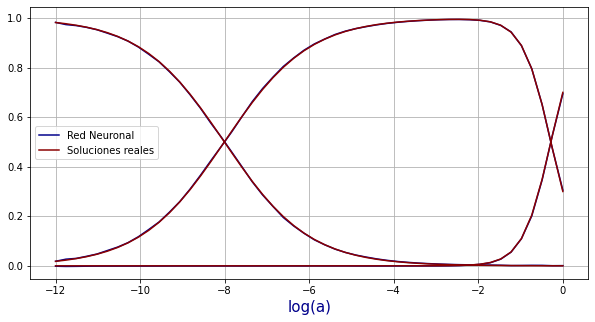

In [85]:
Z=np.linspace(0,-12,50)
dom=[]
dom2=[]
dom3=[]
#Distintas combinaciones de los hiperparámetros, para el modelo keras

for z in Z: dom.append([z,0.5,80]) 
A=model.predict(dom)
A=scaler.inverse_transform(A)

for z in Z: dom2.append([z,0.3,70]) 
B=model.predict(dom2)
B=scaler.inverse_transform(B)

for z in Z: dom3.append([z,0.4,67]) 
C=model.predict(dom3)
C=scaler.inverse_transform(C)
#función real
D=EDO(Z, 0.3,70)



#Comparación entre la real y el modelo
plt.figure(figsize=(10,5))
plt.plot(Z,B[:,0],color='darkblue')
plt.plot(Z,B[:,1],color='darkblue')
plt.plot(Z,B[:,2],color='darkblue', label='Red Neuronal')
#plt.plot(Z,B[:,3])


plt.plot(Z,D[:,0],color='darkred')
plt.plot(Z,D[:,1],color='darkred')
plt.plot(Z,D[:,2],color='darkred', label='Soluciones reales')
#plt.plot(Z,D[:,3])

#plt.title()
plt.xlabel('log(a)', size=15, color='darkblue')
plt.grid()
plt.legend()

##### 2. Soluciones dadas por la red para $O_{m,0}=0.3$ y $H_0=70$

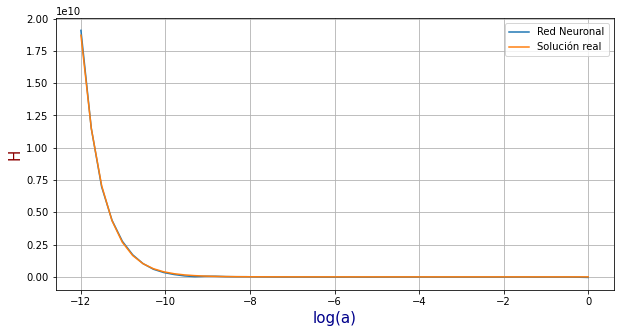

In [93]:
#Comparación entre la real y el modelo
plt.figure(figsize=(10,5))
plt.plot(Z,B[:,3], label='Red Neuronal')
plt.plot(Z,D[:,3], label='Solución real')

#plt.title()
plt.xlabel('log(a)', size=15, color='darkblue')
plt.ylabel('H', size=15, color='darkred')
plt.grid()
plt.legend()

##### 2.1 Cuarta Solución 

In [ ]:
#Comparación entre la real y el modelo
plt.figure(figsize=(10,5))
plt.plot(Z,B[:,0],label='$\Omega_m$')

plt.plot(Z,B[:,2],label='$\Omega_\Lambda$')
#plt.plot(Z,B[:,3])

#plt.title()
plt.xlabel('log(a)', size=15, color='darkblue')
plt.grid()
plt.legend()

##### 3. Soluciones para distintos $O_m$ y $H_0$

Text(0.5, 0, 'log(a)')

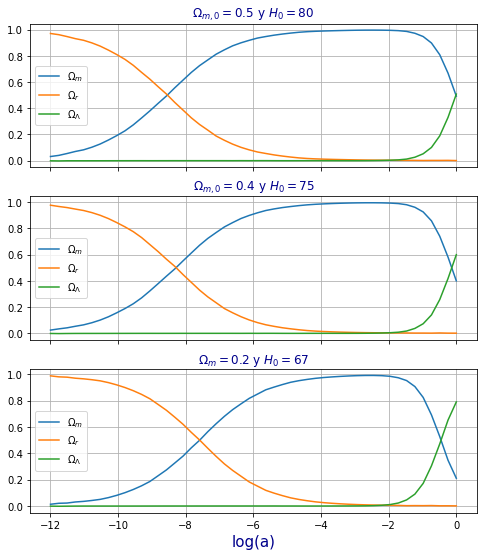

In [84]:
Z=np.linspace(0,-12,50)
dom=[]
dom2=[]
dom3=[]
#Distintas combinaciones de los hiperparámetros, para el modelo keras
for z in Z: dom.append([z,0.5,80]) 
A=model.predict(dom)
A=scaler.inverse_transform(A)

for z in Z: dom2.append([z,0.4,75]) 
B=model.predict(dom2)
B=scaler.inverse_transform(B)

for z in Z: dom3.append([z,0.2,67]) 
C=model.predict(dom3)
C=scaler.inverse_transform(C)

#Gráficas
fig, (ax1, ax2,ax3) = plt.subplots(3, sharex=True, figsize=(8,9))
#fig.suptitle('Soluciones a distintos parámetros', color='darkblue')
ax1.plot(Z, A[:,0], label='$\Omega_m$')
ax1.plot(Z, A[:,1],label='$\Omega_r$')
ax1.plot(Z, A[:,2],label='$\Omega_\Lambda$')
ax1.grid()
ax1.legend()
ax1.set_title('$\Omega_{m,0} = 0.5$ y $H_0 = 80$', color='darkblue')

ax2.plot(Z, B[:,0], label='$\Omega_m$')
ax2.plot(Z, B[:,1],label='$\Omega_r$')
ax2.plot(Z, B[:,2],label='$\Omega_\Lambda$')
ax2.grid()
ax2.legend()
ax2.set_title('$\Omega_{m,0} = 0.4$ y $H_0 = 75$', color='darkblue')

ax3.plot(Z, C[:,0], label='$\Omega_m$')
ax3.plot(Z, C[:,1],label='$\Omega_r$')
ax3.plot(Z, C[:,2],label='$\Omega_\Lambda$')
ax3.set_title('$\Omega_m = 0.2$ y $H_0 = 67$', color='darkblue')
ax3.legend()
ax3.grid()
plt.xlabel('log(a)', size=15, color='darkblue')
